# Dispersion Analysis: Taylor vs. DRP FD Stencils using Devito

This notebook compares the numerical dispersion of explicit finite-difference (FD)
stencils for the second derivative obtained via two methods:

1. **Taylor series FD weights** computed via the Fornberg algorithm.
2. **DRP (Dispersion-Relation-Preserving) stencils** computed by solving a constrained
   least-squares optimization problem.
We then use these coefficients to compute the FD symbol:

\[
S(\beta)= c_0+2\sum_{m=1}^{M} c_m\cos(m\beta),
\]

and for a 2D Laplacian (assuming separability) and a propagation angle \(\alpha\),

\[
S_{2D}(\alpha,\beta)=S(\beta\cos\alpha)+S(\beta\sin\alpha).
\]

Comparing with the continuous symbol \(-\beta^2\) (in normalized form), the numerical phase
velocity ratio is given by:

\[
\delta(\alpha,\beta)=\sqrt{\frac{-S_{2D}(\alpha,\beta)\,h^2}{\beta^2}}.
\]

In an ideal (dispersion-free) FD scheme, \(\delta=1\). We generate plots of \(\delta\)
versus \(\beta\) (for fixed \(\alpha\)) and versus \(\alpha\) (for fixed \(\beta\)), and compare
the Taylor and DRP stencils.

Finally, we show a third plot of \(v_p / v\) *vs.* the time step \(\Delta t\) for a chosen
wavenumber \(\beta\), combining both space (FD) and time (second-order) discretization effects.

For our example:
- An 8th-order scheme (9-point stencil, \(M=4\) on each side).
- Grid spacing \(h=10\) m.
- Illustrative velocity \(v=1500\) m/s.

## 1. Compute Taylor Series FD Weights via Fornberg’s Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def fd_weights(x, x0, n):
    """
    Compute finite difference weights for derivative order n at x0 based on nodes x.
    Implementation of Fornberg's algorithm.
    
    Parameters:
      x : array_like
          Nodes (grid points).
      x0 : float
          The point at which the derivative is approximated.
      n : int
          Order of the derivative.
    
    Returns:
      weights : np.array
          Array of weights.
    """
    m = len(x)
    c = np.zeros((m, n+1))
    c[0,0] = 1.0
    for i in range(1, m):
        c1 = 1.0
        for j in range(i):
            c2 = x[i] - x[j]
            c1 *= c2
            for k in range(min(i, n), 0, -1):
                c[i, k] = ((x[i]-x0)*c[i-1, k] - k*c[i-1, k-1]) / c2
            c[i, 0] = (x[i]-x0)*c[i-1, 0] / c2
        for j in range(i):
            for k in range(min(i, n), 0, -1):
                c[j, k] = ((x0 - x[j])*c[j, k] + k*c[j, k-1]) / (x[i]-x[j])
            c[j, 0] = (x0 - x[j])*c[j, 0] / (x[i]-x[j])
    return c[:, n]

# Set up stencil parameters for an 8th-order scheme (9 points: M=4)
M = 4
h = 10.0  # grid spacing in meters
x = np.arange(-M, M+1, 1.0)  # nodes: -4, -3, ... 0, ... 3, 4
x0 = 0.0

# For the second derivative (n=2)
taylor_weights = fd_weights(x, x0, 2)

print("Taylor Series FD Weights (for 2nd derivative):")
for xi, w in zip(x, taylor_weights):
    print(f"  x = {xi:3.0f}: weight = {w:.6f}")


Taylor Series FD Weights (for 2nd derivative):
  x =  -4: weight = 5.688889
  x =  -3: weight = -8.100000
  x =  -2: weight = 6.844444
  x =  -1: weight = -2.016667
  x =   0: weight = 0.000000
  x =   1: weight = 4.333333
  x =   2: weight = -32.000000
  x =   3: weight = 72.000000
  x =   4: weight = -72.000000


In [2]:
def get_fd_stencil(weights):
    """
    Return the full symmetric FD stencil (length 2*M+1)
    from the array of weights for nodes [-M,...,M].
    """
    return weights  # already in correct order

taylor_stencil = get_fd_stencil(taylor_weights)


In [3]:
# ## 2. Compute DRP FD Weights via Constrained Optimization

from scipy.optimize import minimize

def drp_objective(c, beta_vals):
    """
    Objective: discretized squared error between FD symbol and continuous symbol.
    c: array of length M+1 where c[0] is c_0, and c[m] for m>=1.
    beta_vals: array of beta values over which to minimize error.
    """
    # Compute FD symbol S(beta) = c_0 + 2*sum_{m=1}^M c_m*cos(m*beta)
    # Compare with -beta^2
    S = c[0] + 2 * sum(c[m] * np.cos(m * beta_vals) for m in range(1, len(c)))
    err = S + beta_vals**2
    return np.sum(err**2)

def compute_drp_weights(M, beta_max=np.pi/2, num_beta=200):
    """
    Compute DRP FD weights for the second derivative.
    Returns an array of length (2*M+1) with symmetric weights.
    """
    beta_vals = np.linspace(0, beta_max, num_beta)
    
    # Use the Taylor solution as an initial guess
    init = taylor_stencil[M:]  # c_0,...,c_M from the Taylor stencil
    
    # Define constraints:
    # (1) c_0 + 2*sum_{m=1}^M c_m = 0
    # (2) sum_{m=1}^M m^2*c_m = 1  (to ensure second-order)
    cons = [
        {'type': 'eq',
         'fun': lambda c: c[0] + 2*np.sum(c[1:])},
        {'type': 'eq',
         'fun': lambda c: np.sum([m**2 * c[m] for m in range(1, len(c))]) - 1.0}
    ]
    
    res = minimize(lambda c: drp_objective(c, beta_vals), init, constraints=cons, method='SLSQP')
    if not res.success:
        raise RuntimeError("DRP optimization did not converge.")
    
    c_opt = res.x
    # Build full symmetric stencil
    drp_stencil = np.concatenate((c_opt[:0:-1], c_opt))
    return drp_stencil

drp_stencil = compute_drp_weights(M)

print("\nDRP FD Weights (for 2nd derivative):")
for i, w in enumerate(drp_stencil):
    print(f"  x = {i - M:3d}: weight = {w:.6f}")



DRP FD Weights (for 2nd derivative):
  x =  -4: weight = -0.004496
  x =  -3: weight = 0.042700
  x =  -2: weight = -0.251595
  x =  -1: weight = 1.694024
  x =   0: weight = -2.961264
  x =   1: weight = 1.694024
  x =   2: weight = -0.251595
  x =   3: weight = 0.042700
  x =   4: weight = -0.004496


In [4]:
# ## 3. Define FD Symbol and Dispersion Functions

def S_1d(beta, weights, h):
    """
    Compute the 1D FD symbol for the second derivative.
    weights: assumed symmetric, ordered from x=-M,...,0,...,M.
    """
    M = (len(weights) - 1)//2
    c0 = weights[M]
    # S(beta) = c0 + 2 * sum_{m=1..M} c_m cos(m beta), then divide by h^2
    val = c0
    for m in range(1, M+1):
        val += 2*weights[M + m]*np.cos(m*beta)
    return val / (h**2)

def S_2d(alpha, beta, weights, h):
    """
    2D FD symbol for the Laplacian = S_1d(kx) + S_1d(ky),
    with kx=beta cos(alpha), ky=beta sin(alpha).
    """
    return S_1d(beta*np.cos(alpha), weights, h) + S_1d(beta*np.sin(alpha), weights, h)

def delta(alpha, beta, weights, h):
    """
    Numerical phase velocity ratio delta = v_FD / v
    = sqrt( - S_2d(...) * h^2 / beta^2 ).
    """
    val = S_2d(alpha, beta, weights, h)
    # val is negative if it's approximating -beta^2
    # If val>0, that indicates a sign error or large beta range
    # We'll mask out invalid (val>=0) to avoid sqrt of negative.
    if val >= 0:
        return np.nan
    return np.sqrt((-val * h**2) / (beta**2))


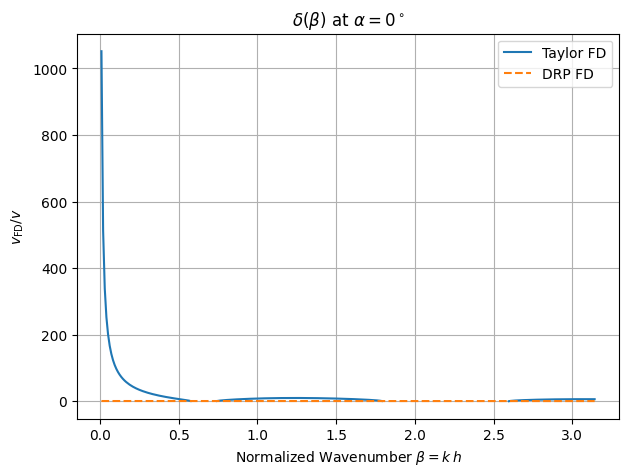

In [5]:
## 4. Generate Dispersion Plots (δ vs. β) and (δ vs. α)

v = 1500.0  # wave speed for reference (just for context)
beta_vals = np.linspace(0.01, np.pi, 300)  # avoid beta=0
alpha_vals = np.linspace(0, np.pi/2, 300)  # from 0 to 90 degrees

# 4a) δ vs. β for alpha=0
alpha_fixed = 0.0
delta_beta_taylor = [delta(alpha_fixed, b, taylor_stencil, h) for b in beta_vals]
delta_beta_drp    = [delta(alpha_fixed, b, drp_stencil,    h) for b in beta_vals]

plt.figure(figsize=(7,5))
plt.plot(beta_vals, delta_beta_taylor, label='Taylor FD')
plt.plot(beta_vals, delta_beta_drp, '--', label='DRP FD')
plt.xlabel(r'Normalized Wavenumber $\beta = k\,h$')
plt.ylabel(r'$v_{\mathrm{FD}}/v$')
plt.title(r'$\delta(\beta)$ at $\alpha=0^\circ$')
plt.legend()
plt.grid(True)
plt.savefig("dispersion_beta.png")  # Save figure
plt.show()


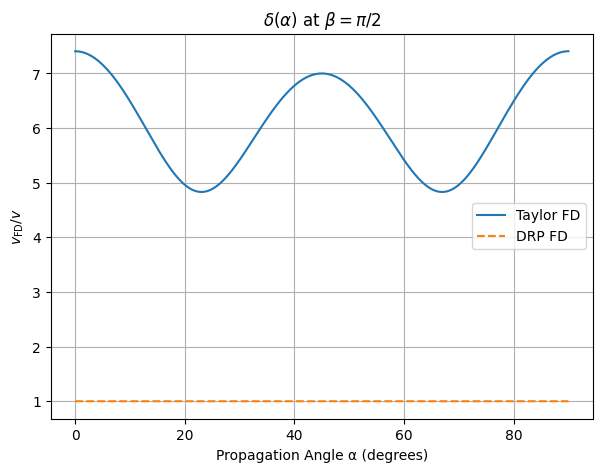

In [6]:
# 4b) δ vs. α for a fixed β
beta_fixed = np.pi/2
delta_alpha_taylor = [delta(a, beta_fixed, taylor_stencil, h) for a in alpha_vals]
delta_alpha_drp    = [delta(a, beta_fixed, drp_stencil,    h) for a in alpha_vals]

plt.figure(figsize=(7,5))
plt.plot(np.degrees(alpha_vals), delta_alpha_taylor, label='Taylor FD')
plt.plot(np.degrees(alpha_vals), delta_alpha_drp, '--', label='DRP FD')
plt.xlabel('Propagation Angle α (degrees)')
plt.ylabel(r'$v_{\mathrm{FD}}/v$')
plt.title(r'$\delta(\alpha)$ at $\beta=\pi/2$')
plt.legend()
plt.grid(True)
plt.savefig("dispersion_alpha.png")  # Save figure
plt.show()



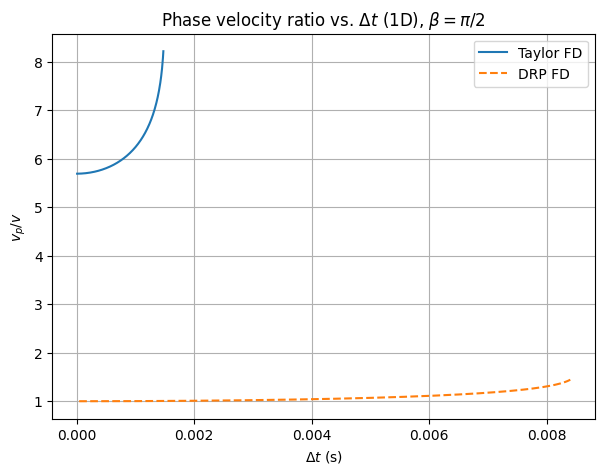

In [7]:
# ## 5. Plot of v_p / v vs. Δt
#
# Now let us consider the *combined* space‐time discretization for a 1D wave equation,
# focusing on how the *numerical* phase velocity changes with the time step \(\Delta t\).
# Using the discrete dispersion relation for the second‐order‐in‐time wave equation
# approximated by our FD stencil in space:
#
# \[
# -\,\frac{4}{\Delta t^2}\,\sin^2\Bigl(\tfrac{\omega\,\Delta t}{2}\Bigr)
# \;=\;
# v^2\,S_{1D}(\beta),
# \]
#
# we solve for \(\omega\) and then define \(v_p = \omega/k\). The ratio \(v_p / v\) is:
#
# \[
# \frac{v_p}{v}
# =
# \frac{2\,h}{\beta\,\Delta t \,v}\;
# \arcsin\!\Bigl(\tfrac{v\,\Delta t}{2}\,\sqrt{-\,S_{1D}(\beta)}\Bigr),
# \quad
# \text{valid when the arcsin argument is }\le 1.
# \]
#
# We'll plot this as \(\Delta t\) goes from 0 up to the stability limit, for a chosen \(\beta\).

def vp_v_ratio_1d(beta, dt, weights, h, v):
    """
    Compute v_p / v for a 1D second-order-in-time wave equation
    with spatial FD symbol S_1d for wavenumber beta.
    
    The discrete dispersion relation in time gives:
       sin^2( (omega dt)/2 ) = v^2 dt^2 [ - S_1d(beta) ] / 4
    =>  omega dt / 2 = arcsin(...)
    =>  omega = (2/dt)*arcsin(...)
    =>  v_p = omega/k = ...
    =>  v_p / v = ...
    
    Return np.nan if invalid (arcsin argument > 1).
    """
    val_s = S_1d(beta, weights, h)  # This should be negative for valid modes
    gamma = -val_s
    if gamma <= 0:
        return np.nan
    
    arg = 0.5 * v * dt * np.sqrt(gamma)
    if arg > 1.0:
        return np.nan
    # formula for v_p / v:
    # = (2*h/(beta * dt * v)) * arcsin(arg)
    return (2.0*h/(beta * dt * v)) * np.arcsin(arg)

# Choose beta for demonstration
beta_plot = np.pi/2

# For each scheme (Taylor/DRP), define dt up to stability limit
def max_stable_dt(beta, weights, h, v):
    """Compute the dt at which arcsin(...) argument = 1."""
    val_s = S_1d(beta, weights, h)
    gamma = -val_s
    if gamma <= 0:
        return 0.0
    # We want 0.5 * v * dt * sqrt(gamma) = 1 => dt = 2/(v * sqrt(gamma))
    return 2.0 / (v * np.sqrt(gamma))

dt_max_taylor = max_stable_dt(beta_plot, taylor_stencil, h, v)
dt_max_drp    = max_stable_dt(beta_plot, drp_stencil,    h, v)

# We'll plot from dt=0 up to (say) 0.99*dt_max for each scheme
num_points = 200
dt_vals_taylor = np.linspace(0, 0.99*dt_max_taylor, num_points)[1:]  # skip 0
dt_vals_drp    = np.linspace(0, 0.99*dt_max_drp,    num_points)[1:]

vpv_taylor = [vp_v_ratio_1d(beta_plot, dt, taylor_stencil, h, v) for dt in dt_vals_taylor]
vpv_drp    = [vp_v_ratio_1d(beta_plot, dt, drp_stencil,    h, v) for dt in dt_vals_drp]

plt.figure(figsize=(7,5))
plt.plot(dt_vals_taylor, vpv_taylor, label='Taylor FD')
plt.plot(dt_vals_drp,    vpv_drp, '--', label='DRP FD')
plt.xlabel(r'$\Delta t$ (s)')
plt.ylabel(r'$v_p / v$')
plt.title(r'Phase velocity ratio vs. $\Delta t$ (1D), $\beta=\pi/2$')
plt.legend()
plt.grid(True)
plt.savefig("dispersion_dt.png")
plt.show()


In [8]:
# ## 6. Inspecting Devito Operator Code
#

from devito import Grid, TimeFunction, Eq, Operator, configuration
configuration['log-level'] = 'WARNING'

shape = (101, 101)
spacing = (10.0, 10.0)
grid = Grid(shape=shape, extent=(shape[0]*spacing[0], shape[1]*spacing[1]))
u = TimeFunction(name='u', grid=grid, time_order=2, space_order=8)

eq = Eq(u.dt2, v**2 * u.laplace)
op = Operator(eq, subs={u.dt: 0.0005})  # example dt

# Convert the Devito internal code IR to string, then show snippet
print("\nDevito-generated operator code snippet:")
code_str = str(op.ccode)
print(code_str[:600], "...")



Devito-generated operator code snippet:
#define _POSIX_C_SOURCE 200809L
#define START(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"

struct dataobj
{
  void *restrict data;
  unsigned long * size;
  unsigned long * npsize;
  unsigned long * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
  void * dmap;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(struct dataobj *r ...
